# Exploratory data analysis of short sale disclosures

This notebook contains an exploratory data analysis of the FCA short-sale disclosure dataset. 

The main questions I want to investigate are:

1. What is the correlation between the aggregrate short position and the subsequent price movement over different time periods?
2. How skilled are investment managers when it comes to shorts?

Context and discussion is given in the accompanying blog post.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plt.style.use("seaborn-deep")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14

In [3]:
df = pd.read_excel("data/short_positions.xls", sheet_name=1)
df.columns=["investor", "company", "ISIN", "position", "date"]
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
print(df.shape)
df.head()

(64506, 5)


,investor,company,ISIN,position,date
0,AlphaGen Capital Limited,1SPATIAL PLC,GB00B09LQS34,0.00,2013-06-24
1,AlphaGen Capital Limited,1SPATIAL PLC,GB00B09LQS34,1.42,2013-05-29
2,AlphaGen Capital Limited,1SPATIAL PLC,GB00B09LQS34,0.71,2013-05-24
3,Lombard Odier Asset Management (Europe) Limited,4IMPRINT GROUP PLC,GB0006640972,0.46,2018-11-02
4,Lombard Odier Asset Management (Europe) Limited,4IMPRINT GROUP PLC,GB0006640972,0.51,2018-11-01


In [4]:
# Breakdown by region
df["ISIN"].str.slice(0, 2).value_counts().head(10)

GB    59619
JE     1357
IE     1054
BM      689
IM      465
IL      364
GG      182
ES      172
GI      107
LU       96
Name: ISIN, dtype: int64

In [5]:
# Write ISINs to file so we can collect data
with open("data/raw_isin.txt", "w") as f:
    for line in set(df.ISIN):
        f.write(f"{line}\n")

## Acquiring tickers and prices

First, we need to do some web scraping to construct a mapper from ISIN to ticker. I did this by using headless chrome and the yahoo finance search. The result is saved in the json file `isin_mapper.json`.

In [6]:
# # Downloading price data
# with open("data/isin_mapper.json", "r") as f:
#     isin_mapper =json.load(f)

# tickerlist = list(isin_mapper.values())
# prices = yf.download(tickerlist)["Adj Close"]
# prices.tail()

In [7]:
# prices.to_csv("data/short_price_data.csv")

In [8]:
prices = pd.read_csv("data/short_price_data.csv", parse_dates=True, index_col="Date")
prices = prices.resample("D").ffill()
prices.tail()

,2695.T,4331.T,6584.T,888.L,AA.L,AAL.L,AAOG.L,AAS.L,ABC.L,ABF.L,...,WG.L,WIL.L,WINE.L,WIZZ.L,WJG.L,WMH.L,WPP.L,WTB.L,XAR.L,XPP.L
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-14,4565.0,605.0,670.0,135.199997,18.900000,1364.199951,0.425,836.000000,1394.0,1664.5,...,167.949997,126.5,400.0,2626.0,144.0000,106.750000,558.200012,2558.0,59.000000,2840.0
2020-05-15,4595.0,614.0,683.0,137.600006,18.200001,1433.800049,0.500,851.000000,1366.0,1624.0,...,170.850006,124.0,410.0,2604.0,150.0000,115.349998,557.599976,2667.0,59.400002,2890.0
2020-05-16,4595.0,614.0,683.0,137.600006,18.200001,1433.800049,0.500,851.000000,1366.0,1624.0,...,170.850006,124.0,410.0,2604.0,150.0000,115.349998,557.599976,2667.0,59.400002,2890.0
2020-05-17,4595.0,614.0,683.0,137.600006,18.200001,1433.800049,0.500,851.000000,1366.0,1624.0,...,170.850006,124.0,410.0,2604.0,150.0000,115.349998,557.599976,2667.0,59.400002,2890.0
2020-05-18,4665.0,608.0,672.0,141.115997,19.690001,1540.000000,0.450,850.359924,1387.0,1680.0,...,178.600006,NaN,411.5,2774.0,151.8125,116.750000,569.738525,2748.0,63.000000,2950.0


In [9]:
# Useful for joining
prices_melted = (
    prices
    .reset_index()
    .rename({"Date": "date"}, axis=1)
    .melt(id_vars=["date"], var_name="ticker", value_name="price")
    .dropna()
)
print(prices_melted.shape)
prices_melted.head()

(3164131, 3)


,date,ticker,price
13421,2005-09-29,2695.T,31.878222
13422,2005-09-30,2695.T,31.553492
13423,2005-10-01,2695.T,31.553492
13424,2005-10-02,2695.T,31.553492
13425,2005-10-03,2695.T,31.986467


## Data preprocessing

In [10]:
import json

# Read in the mapper we created
with open("data/isin_mapper.json", "r") as f:
    isin_mapper = json.load(f)

In [11]:
# Map ISIN to ticker and remove unneccessary collumns
df["ticker"] = df["ISIN"].map(isin_mapper)
df = df.drop(["company", "ISIN"], axis=1)
df.head()

,investor,position,date,ticker
0,AlphaGen Capital Limited,0.00,2013-06-24,NaN
1,AlphaGen Capital Limited,1.42,2013-05-29,NaN
2,AlphaGen Capital Limited,0.71,2013-05-24,NaN
3,Lombard Odier Asset Management (Europe) Limited,0.46,2018-11-02,FOUR.L
4,Lombard Odier Asset Management (Europe) Limited,0.51,2018-11-01,FOUR.L


In [12]:
# Some prices (I think belonging to illiquid instruments) have unrealistically high volatility
# e.g 1 -> 500 -> 1. Thse should be removed
stupid = (prices.pct_change() > 2).any(axis=0) | (prices < 0).any(axis=0)

avl_tickers = list(prices.columns)
avl_tickers = [t for t in avl_tickers if not stupid[t]]
print(len(avl_tickers))
avl_tickers[:10]

423


['4331.T',
 '6584.T',
 '888.L',
 'AA.L',
 'AAL.L',
 'AAOG.L',
 'ABC.L',
 'ABF.L',
 'ACRL.L',
 'ACSO.L']

In [13]:
# Drop tickers that are missing or stupid
df = df.dropna(subset=["ticker"], axis=0)
df = df[df.ticker.isin(avl_tickers)].reset_index(drop=True)
print(df.shape)
df.head()

(50661, 4)


,investor,position,date,ticker
0,Lombard Odier Asset Management (Europe) Limited,0.46,2018-11-02,FOUR.L
1,Lombard Odier Asset Management (Europe) Limited,0.51,2018-11-01,FOUR.L
2,AlphaGen Capital Limited,0.48,2013-05-16,888.L
3,AlphaGen Capital Limited,0.50,2013-04-24,888.L
4,Millennium International Management LP,0.49,2017-09-22,888.L


## Data exploration

### Changes in position for a given investor/company

```
A public share notification must be made when the net short positions of shares reach 0.5% of the issued share capital of the company concerned, and again at each 0.1% increment after that. 

This relates to both increases and decreases of the position (including each time the position drops from 0.5% or above to below 0.5%). 

If you have previously disclosed a position publicly and that position then falls below 0.5%, you must make the new position public.
```

Thus this dataset gives us a complete picture of entry/exits of large short positions!

In [14]:
df.groupby(["investor", "ticker"]).count().position.idxmax()

('Marshall Wace LLP', 'SBRY.L')

In [15]:
pos_df = df[(df.investor == "Marshall Wace LLP") & (df.ticker == "SBRY.L")][["date", "position"]]
print(pos_df.shape)
pos_df = pos_df.iloc[::-1]
pos_df.head()

(224, 2)


,date,position
38931,2014-01-31,0.51
38930,2014-02-05,0.48
38929,2014-02-11,0.54
38928,2014-02-17,0.49
38927,2014-02-18,0.50


In [16]:
pos_df.date.min()

Timestamp('2014-01-31 00:00:00')

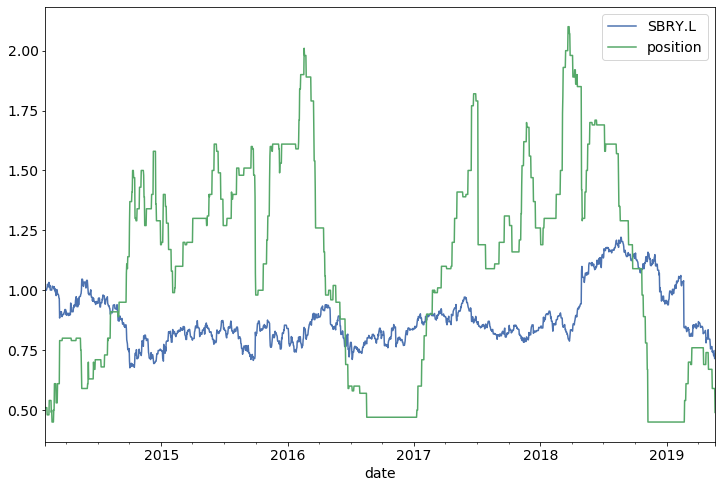

In [17]:
# View both prices and position on the same chart. by
sbry_prices = (
    prices["SBRY.L"]
    .dropna()
    .reindex(pd.date_range(pos_df.date.min(), pos_df.date.max()))
    .reset_index()
    .rename({"index":"date"}, axis=1)
)
pos_prices = pd.merge(sbry_prices, pos_df, how="left").set_index("date").ffill()
pos_prices["SBRY.L"] /= pos_prices["SBRY.L"].iloc[0]
pos_prices.plot();

### Most active participants and most shorted stocks


In [18]:
# Most active participants
df["investor"].value_counts()[:20]

Marshall Wace LLP                                              6924
BlackRock Investment Management (UK) Limited                   4530
GLG Partners LP                                                3289
AQR Capital Management, LLC                                    2533
WorldQuant LLC                                                 2113
Millennium International Management LP                         1960
ODEY ASSET MANAGEMENT LLP                                      1558
BlackRock Institutional Trust Company, National Association    1424
Citadel Europe LLP                                             1352
Merian Global Investors (UK) Limited                           1008
JPMorgan Asset Management (UK) Ltd                              931
GSA Capital Partners LLP                                        902
AHL Partners LLP                                                732
Henderson Global Investors                                      714
AKO Capital LLP for AKO Master Fund Limited     

In [19]:
# Rough calculation for 10 stocks with highest short interest
(
    df.groupby(["investor", "ticker"])["position"]
    .mean()
    .reset_index()
    .groupby("ticker")
    .sum()
    .sort_values(by="position", ascending=False)
    .head(10)
)

,position
ticker,
OCDO.L,37.930474
MRO.L,35.543866
PMO.L,30.909869
WEIR.L,30.410035
WG.L,30.062299
CINE.L,29.895159
MRW.L,28.912492
TLW.L,28.060108
SBRY.L,26.838042


In [20]:
# Find the most recent disclosed position before a certain date
df.groupby([df.date.dt.year, df.date.dt.month]).count()

investor  position  date  ticker
date date                                  
2012 10           3         3     3       3
     11         296       296   296     296
     12         107       107   107     107
2013 1          192       192   192     192
     2          194       194   194     194
...             ...       ...   ...     ...
2020 1          672       672   672     672
     2          796       796   796     796
     3         1571      1571  1571    1571
     4          818       818   818     818
     5          191       191   191     191

[92 rows x 4 columns]

In [21]:
# Manager with the most diverse set of shorts
df.groupby(["investor"]).nunique().ticker.idxmax()

'BlackRock Investment Management (UK) Limited'

## Trading signals

### 1. Predictivity of an individual position

For this (very crude) signal, we examine how an individual short position correlates with the subsequent price change over different periods.

This is a very poor indicator because it does not do any grouping or aggregration, but I am using it to get some sense of the relationships involved.

In [22]:
# Merge prices
rets_df = pd.merge(df, prices_melted, how="inner", left_on=["date", "ticker"], right_on=["date", "ticker"])
rets_df.head()

,investor,position,date,ticker,price
0,Lombard Odier Asset Management (Europe) Limited,0.46,2018-11-02,FOUR.L,1913.145386
1,Lombard Odier Asset Management (Europe) Limited,0.51,2018-11-01,FOUR.L,1951.408325
2,AlphaGen Capital Limited,0.48,2013-05-16,888.L,139.149078
3,AlphaGen Capital Limited,0.50,2013-04-24,888.L,126.796761
4,Millennium International Management LP,0.49,2017-09-22,888.L,228.430862


In [23]:
# Merge returns for different periods
time_periods = [("ret_1d", 1), ("ret_1w", 7), ("ret_1mo", 30), ("ret_3mo", 90), ("ret_1y", 365)]
for name, period in time_periods:
    ret = prices.pct_change(period).shift(-period).dropna(how="all")
    ret_melted = ret.reset_index().rename({"Date": "date"}, axis=1).melt(id_vars=["date"],var_name="ticker", value_name=name)
    rets_df = pd.merge(rets_df, ret_melted, how="left", left_on=["date", "ticker"], right_on=["date", "ticker"])
rets_df.head()

,investor,position,date,ticker,price,ret_1d,ret_1w,ret_1mo,ret_3mo,ret_1y
0,Lombard Odier Asset Management (Europe) Limited,0.46,2018-11-02,FOUR.L,1913.145386,0.000000,-0.040000,0.020000,-0.007500,0.512352
1,Lombard Odier Asset Management (Europe) Limited,0.51,2018-11-01,FOUR.L,1951.408325,-0.019608,-0.063726,0.000000,-0.019608,0.482698
2,AlphaGen Capital Limited,0.48,2013-05-16,888.L,139.149078,-0.011751,-0.074986,-0.175713,-0.107443,-0.240386
3,AlphaGen Capital Limited,0.50,2013-04-24,888.L,126.796761,0.022222,0.024625,-0.016192,-0.000840,-0.057792
4,Millennium International Management LP,0.49,2017-09-22,888.L,228.430862,0.000000,0.007454,-0.037269,0.105924,-0.096052


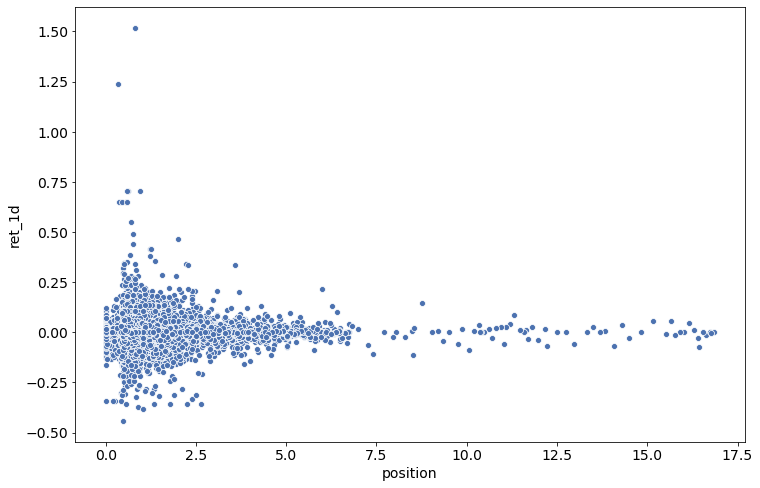

In [24]:
sns.scatterplot(x="position", y="ret_1d", data=rets_df)
plt.show()

In [25]:
# Information coefficeints
for col in rets_df.columns[5:]:
    subset = rets_df[["position", col]].dropna(how="any")
    r, pval = stats.spearmanr(subset["position"], subset[col])
    print(f"{col:<10}: r = {r:.2g}, pval = {pval:.2g}")

ret_1d    : r = -0.00026, pval = 0.95
ret_1w    : r = 0.0026, pval = 0.57
ret_1mo   : r = 0.015, pval = 0.0013
ret_3mo   : r = 0.015, pval = 0.0014
ret_1y    : r = 0.018, pval = 0.00027


Interestingly, there are statistically significant relationships in the *other* direction, over time horizons longer than 1 month. This could be due the natural upwards bias of equity markets, or it could be evidence for the "short squeeze" phenomenon, wherein investors covering shorts are forced to buy-back shares.

### 2. Intelligent short interest for Ocado

Once over the 0.5% mark, investment firms are legally obliged to disclose once they go below it. Thus a reasonable proxy for the net "intelligent" short interest for a ticker at any date is to sum over all of the most recent shorts above 0.50. 

We will start by investigating a single highly ticker, before a cross sectional analysis.

In [26]:
# Find ticker with most number of investors shorting
df.groupby("ticker")["investor"].nunique().sort_values(ascending=False).head(10)

ticker
OCDO.L    45
WG.L      43
CINE.L    40
MRO.L     38
SBRY.L    37
WEIR.L    37
PFC.L     35
MRW.L     34
ASC.L     34
TLW.L     33
Name: investor, dtype: int64

In [27]:
ticker = "OCDO.L"
ticker_df = df[df.ticker == ticker].drop("ticker", axis=1)
print(ticker_df.shape)
ticker_df.head()

(898, 3)


,investor,position,date
29456,Altair Investment Management Limited,0.49,2018-02-14
29457,Altair Investment Management Limited,0.54,2018-02-09
29458,Altair Investment Management Limited,0.61,2018-02-06
29459,Altair Investment Management Limited,0.85,2017-11-28
29460,"AQR Capital Management, LLC",0.78,2020-03-30


In [28]:
ticker_df = ticker_df.pivot(index="date", columns="investor", values="position")
ticker_df.head()

investor,"AQR Capital Management, LLC",Altair Investment Management Limited,Ardevora Asset Management LLP,"BlackRock Institutional Trust Company, National Association",BlackRock Investment Management (UK) Limited,"Blue Ridge Capital, L.L.C.",BlueCrest Capital Management Limited,"CPMG, Inc.","Calixto Global Investors, LP","Coatue Management, L.L.C.",...,Saemor Capital B.V.,"Shannon River Fund Management, LLC","Sheffield Asset Management, L.L.C.",Sylebra Capital Limited,Systematica Investments Limited,TIMF LP,TT International,UBS Asset Management (UK) Ltd,Whale Rock Capital Management LLC,WorldQuant LLC
date,,,,,,,,,,,,,,,,,,,,,
2012-11-01,NaN,NaN,0.55,NaN,2.59,2.41,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-11-07,NaN,NaN,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-11-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-11-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
ticker_df = ticker_df.reindex(pd.date_range(ticker_df.index[0], ticker_df.index[-1])).ffill()
ticker_df.tail()

investor,"AQR Capital Management, LLC",Altair Investment Management Limited,Ardevora Asset Management LLP,"BlackRock Institutional Trust Company, National Association",BlackRock Investment Management (UK) Limited,"Blue Ridge Capital, L.L.C.",BlueCrest Capital Management Limited,"CPMG, Inc.","Calixto Global Investors, LP","Coatue Management, L.L.C.",...,Saemor Capital B.V.,"Shannon River Fund Management, LLC","Sheffield Asset Management, L.L.C.",Sylebra Capital Limited,Systematica Investments Limited,TIMF LP,TT International,UBS Asset Management (UK) Ltd,Whale Rock Capital Management LLC,WorldQuant LLC
2020-05-09,0.78,0.49,0.12,0.49,0.49,0.23,0.44,0.43,0.42,0.3,...,0.47,0.38,0.49,0.35,0.49,0.42,0.43,0.42,1.09,0.48
2020-05-10,0.78,0.49,0.12,0.49,0.49,0.23,0.44,0.43,0.42,0.3,...,0.47,0.38,0.49,0.35,0.49,0.42,0.43,0.42,1.09,0.48
2020-05-11,0.78,0.49,0.12,0.49,0.49,0.23,0.44,0.43,0.42,0.3,...,0.47,0.38,0.49,0.35,0.49,0.42,0.43,0.42,1.09,0.48
2020-05-12,0.78,0.49,0.12,0.49,0.49,0.23,0.44,0.43,0.42,0.3,...,0.47,0.38,0.49,0.35,0.49,0.42,0.43,0.42,0.57,0.48
2020-05-13,0.78,0.49,0.12,0.49,0.49,0.23,0.44,0.43,0.42,0.3,...,0.47,0.38,0.49,0.35,0.49,0.42,0.43,0.42,0.27,0.48


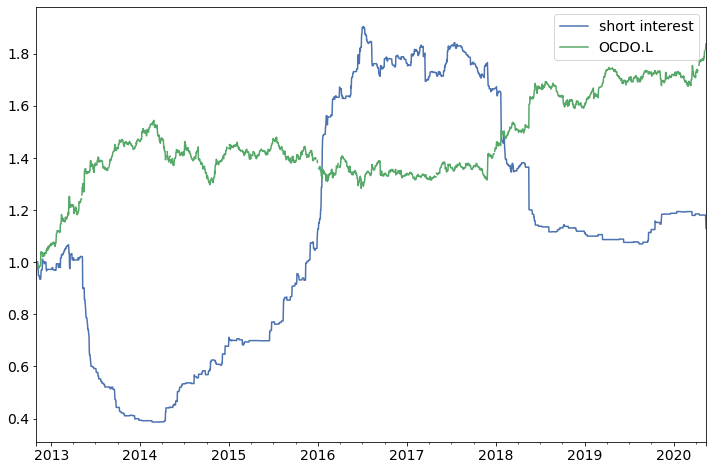

In [30]:
short_interest = ticker_df.sum(axis=1).rename("short interest")
si = pd.DataFrame(short_interest).join(prices[ticker])
si["OCDO.L"] = np.log(si["OCDO.L"])  # log transform to make more visible
si /= si.iloc[0]
si.plot();

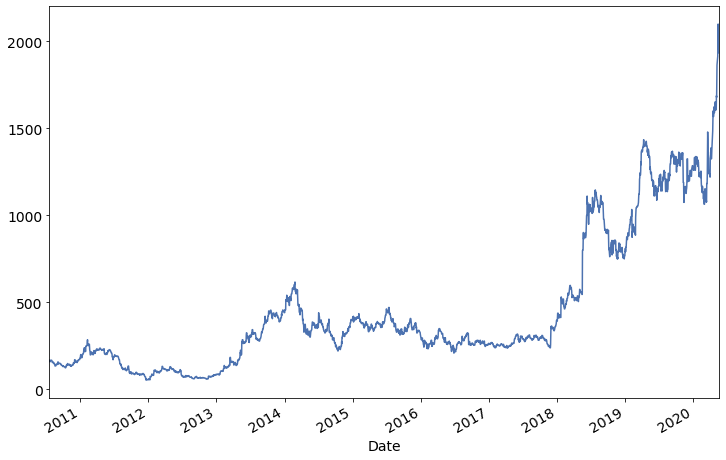

In [31]:
prices["OCDO.L"].dropna().plot();

In [32]:
 # Merge returns for different periods
si_rets = pd.DataFrame(short_interest)
time_periods = [("ret_1d", 1), ("ret_1w", 7), ("ret_1mo", 30), ("ret_3mo", 90), ("ret_1y", 365)]
for name, period in time_periods:
    ret = prices[ticker].pct_change(period).shift(-period).dropna(how="all").rename(name)
    si_rets = si_rets.join(ret)
si_rets = si_rets.dropna(how="all", subset=[p[0] for p in time_periods])
si_rets.head()

,short interest,ret_1d,ret_1w,ret_1mo,ret_3mo,ret_1y
2012-11-01,15.85,-0.024922,-0.086449,0.151090,0.643302,5.831776
2012-11-02,15.87,0.000000,-0.065495,0.180511,0.690096,6.006390
2012-11-03,15.87,0.000000,-0.065495,0.134185,0.693291,6.006390
2012-11-04,15.87,0.005591,-0.065495,0.134185,0.693291,5.998403
2012-11-05,15.87,-0.004766,-0.070691,0.182685,0.683876,5.956314


In [33]:
for col in si_rets.columns[1:]:
    subset = si_rets[["short interest", col]].dropna(how="any")
    r, pval = stats.spearmanr(subset["short interest"], subset[col])
    print(f"{col:<10}: r = {r:.2g}, r^2 = {r**2:.2g}, pval = {pval:.2g}")

ret_1d    : r = 0.0069, r^2 = 4.7e-05, pval = 0.72
ret_1w    : r = 0.0029, r^2 = 8.5e-06, pval = 0.88
ret_1mo   : r = 0.012, r^2 = 0.00015, pval = 0.53
ret_3mo   : r = 0.068, r^2 = 0.0047, pval = 0.00042
ret_1y    : r = 0.51, r^2 = 0.26, pval = 2e-157


At least for Ocado, this data seems to mirror the earlier analysis. This is likely due to the fact that Ocado experienced a major bull run. A better indicator would arise if we generalised this to all tickers. 

## Cross sectional short factor

Now, we use the net intelligent short interest in a security at a given date as an alpha factor. The hard part here is data processing: we need to sum across all investment managers for a given ticker and before a given date, forward filling missing dates. There might be an elegant groupby that accomplishes this, but because of the "dimensionality", I have chosen to break it into a for loop and a groupby. The computation runs surprisingly quickly, so I'm not hugely worried about efficiency.

Once we have processed the data, we can use the glorious Alphalens library to understand the information coefficient of the intelligent short interest as an alpha factor.

In [34]:
from alphalens.utils import get_clean_factor_and_forward_returns 
from alphalens.tears import create_full_tear_sheet, create_returns_tear_sheet, create_summary_tear_sheet

In [35]:
len(df.ticker.unique())

423

In [36]:
short_interest_values = []
for ticker in df.ticker.unique():
    ticker_df = (
        df[df.ticker == ticker].drop("ticker", axis=1)
        .drop_duplicates(subset=["investor", "date"], keep="first")
        .pivot(index="date", columns="investor", values="position")
        .resample("D").ffill()
        .sum(axis=1).rename(ticker)
    )
    short_interest_values.append(ticker_df)

In [37]:
short_interest_df = pd.concat(short_interest_values, axis=1).fillna(0)
short_interest_df

,FOUR.L,888.L,BAG.L,AA.L,ABC.L,AY,ACSO.L,ACRL.L,ADM.L,AMS.L,...,SMWH.L,WTB.L,WMH.L,WIL.L,WIZZ.L,MRW.L,WG.L,WPP.L,XAR.L,XPP.L
date,,,,,,,,,,,,,,,,,,,,,
2012-10-31,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00
2012-11-01,0.0,0.0,0.00,0.0,0.5,0.0,0.00,0.0,3.14,0.0,...,8.19,0.0,0.84,0.83,0.0,2.51,0.0,0.64,0.0,3.31
2012-11-02,0.0,0.0,0.00,0.0,0.5,0.0,0.00,0.0,3.14,0.0,...,8.19,0.0,0.98,0.83,0.0,2.51,0.0,0.64,0.0,3.31
2012-11-03,0.0,0.0,0.00,0.0,0.5,0.0,0.00,0.0,3.14,0.0,...,8.19,0.0,0.98,0.83,0.0,2.51,0.0,0.64,0.0,3.31
2012-11-04,0.0,0.0,0.00,0.0,0.5,0.0,0.00,0.0,3.14,0.0,...,8.19,0.0,0.98,0.83,0.0,2.51,0.0,0.64,0.0,3.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-10,0.0,0.0,2.90,0.0,0.0,0.0,1.56,0.0,0.00,0.0,...,0.00,0.0,0.00,0.00,0.0,1.09,0.0,0.00,0.0,0.00
2020-05-11,0.0,0.0,2.28,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.00,0.0,0.00,0.00,0.0,1.09,0.0,0.00,0.0,0.00
2020-05-12,0.0,0.0,2.28,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.00,0.0,0.00,0.00,0.0,1.09,0.0,0.00,0.0,0.00


In [38]:
short_interest_factor = short_interest_df.stack()
short_interest_factor = short_interest_factor[short_interest_factor > 0]
short_interest_factor

date               
2012-10-31  IPO.L      0.99
            SBRY.L     0.76
            WEIR.L     0.62
2012-11-01  ABC.L      0.50
            ADM.L      3.14
                       ... 
2020-05-13  TUI1.DE    0.84
            VCT.L      0.78
            MRW.L      2.33
2020-05-14  MCRO.L     0.49
            WINE.L     0.44
Length: 565314, dtype: float64

In [39]:
short_interest_factor_data = get_clean_factor_and_forward_returns(
    short_interest_factor,
    prices,
    quantiles=5,
    periods=(1, 7, 30, 90, 180), 
    filter_zscore=None)

Dropped 7.4% entries from factor data: 7.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [40]:
short_interest_factor_data

1D        7D       30D       90D      180D  factor  \
date       asset                                                              
2012-10-31 IPO.L   0.006768 -0.043993 -0.052453  0.110829  0.294416    0.99   
           SBRY.L -0.001128 -0.005922 -0.023131 -0.041158  0.093326    0.76   
           WEIR.L  0.029851  0.020092  0.084960  0.154994  0.276694    0.62   
2012-11-01 ABC.L   0.001928 -0.025707 -0.073908  0.011568  0.133356    0.50   
           ADM.L  -0.053415 -0.107706 -0.020140  0.084063  0.121716    3.14   
...                     ...       ...       ...       ...       ...     ...   
2019-11-20 WMH.L   0.015075  0.025405  0.006979  0.008654 -0.308537    0.48   
           WIZZ.L  0.006452  0.007742  0.027097  0.138581 -0.284129    0.48   
           MRW.L  -0.004540  0.012863  0.012358 -0.084994 -0.044136    1.23   
           WG.L   -0.008865  0.053760  0.085502  0.141836 -0.409653    2.70   
           XPP.L   0.017986  0.053957  0.046738  0.159018  0.082138    0.80   

                   factor_quantile  
date       asset                    
2012-10-31 IPO.L                 5  
           SBRY.L                3  
           WEIR.L                1  
2012-11-01 ABC.L                 1  
           ADM.L                 5  
...                            ...  
2019-11-20 WMH.L                 1  
           WIZZ.L                1  
           MRW.L                 5  
           WG.L                  5  
           XPP.L                 4  

[523430 rows x 7 columns]

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.01,0.66,0.389623,0.109091,120749,23.068796
2,0.44,0.99,0.490631,0.022277,111329,21.269129
3,0.49,1.46,0.582416,0.075851,85336,16.303231
4,0.51,2.44,0.806065,0.143281,102165,19.518369
5,0.73,19.18,1.814089,1.064380,103851,19.840475


Returns Analysis


,1D,7D,30D,90D,180D
Ann. alpha,0.007,0.003,0.005,0.001,0.001
beta,1.032,1.038,1.055,1.066,1.076
Mean Period Wise Return Top Quantile (bps),2.185,2.242,2.520,2.085,1.442
Mean Period Wise Return Bottom Quantile (bps),2.928,2.796,2.735,2.865,2.313
Mean Period Wise Spread (bps),-0.743,-0.622,-0.279,-0.816,-0.931


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Information Analysis


,1D,7D,30D,90D,180D
IC Mean,-0.004,-0.006,-0.007,-0.021,-0.031
IC Std.,0.088,0.092,0.093,0.095,0.096
Risk-Adjusted IC,-0.048,-0.063,-0.077,-0.220,-0.320
t-stat(IC),NaN,-3.202,-3.922,-11.192,-16.244
p-value(IC),NaN,0.001,0.000,0.000,0.000
IC Skew,NaN,-0.394,-0.441,0.092,0.032
IC Kurtosis,NaN,5.201,4.606,-0.032,-0.343


Turnover Analysis


,1D,7D,30D,90D,180D
Quantile 1 Mean Turnover,0.026,0.106,0.233,0.385,0.490
Quantile 2 Mean Turnover,0.043,0.159,0.295,0.432,0.519
Quantile 3 Mean Turnover,0.083,0.315,0.575,0.747,0.822
Quantile 4 Mean Turnover,0.073,0.256,0.456,0.631,0.735
Quantile 5 Mean Turnover,0.057,0.195,0.333,0.460,0.554


,1D,7D,30D,90D,180D
Mean Factor Rank Autocorrelation,0.975,0.891,0.763,0.611,0.491


<Figure size 864x576 with 0 Axes>

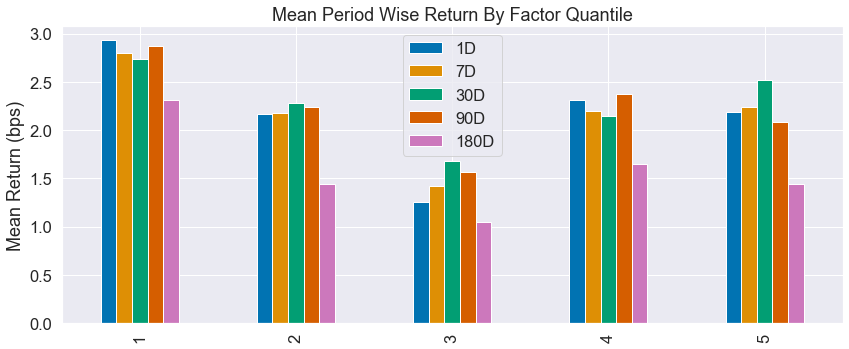

In [41]:
create_summary_tear_sheet(short_interest_factor_data, long_short=False)

As a factor, the intelligent short interest is absolutely garbage. Its quantiles offer no discriminating power – the stocks with the highest short interest perform about as well as those with the lowest short interest. Interestingly, both perform positively, suggesting that the short interest has no predictive power – if anything, it's a predictor of positive returns.

However, it is often the case that where certain test factors provide no alpha, the deltas in the alpha might. To that end, we will compute a new factor called `si_change`, the change in the intelligent short interest from the previous day to the current day. We hypothesise that increases in intelligent short interest are predictive of lower returns.

In [42]:
si_change_df = short_interest_df.diff()
si_change_factor = si_change_df.stack()
si_change_factor = si_change_factor[si_change_factor != 0]
si_change_factor_data = get_clean_factor_and_forward_returns(
    si_change_factor,
    prices,
    quantiles=5,
    periods=(1, 7, 30, 90, 180), 
    filter_zscore=None)

Dropped 12.5% entries from factor data: 12.2% in forward returns computation and 0.3% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [43]:
si_change_factor_data

1D        7D       30D       90D      180D  factor  \
date       asset                                                              
2012-11-01 ABC.L   0.001928 -0.025707 -0.073908  0.011568  0.133356    0.50   
           ADM.L  -0.053415 -0.107706 -0.020140  0.084063  0.121716    3.14   
           AGK.L   0.010114 -0.007816  0.026204 -0.258852 -0.173800    2.88   
           AHT.L   0.003175  0.025132  0.013757  0.208319  0.559506    0.58   
           ASC.L   0.009462 -0.047742  0.064946  0.112258  0.376344    2.52   
...                     ...       ...       ...       ...       ...     ...   
2019-11-20 WEIR.L -0.003250  0.047309  0.103286 -0.029252 -0.287117    0.72   
           WTB.L   0.002954  0.052488  0.097705  0.085890 -0.375596   -0.10   
           WMH.L   0.015075  0.025405  0.006979  0.008654 -0.308537   -0.02   
           MRW.L  -0.004540  0.012863  0.012358 -0.084994 -0.044136    0.21   
           WG.L   -0.008865  0.053760  0.085502  0.141836 -0.409653    1.38   

                   factor_quantile  
date       asset                    
2012-11-01 ABC.L               1.0  
           ADM.L               5.0  
           AGK.L               5.0  
           AHT.L               1.0  
           ASC.L               5.0  
...                            ...  
2019-11-20 WEIR.L              5.0  
           WTB.L               2.0  
           WMH.L               3.0  
           MRW.L               4.0  
           WG.L                5.0  

[36665 rows x 7 columns]

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-14.74,0.64,-1.053674,1.056695,8103,22.100095
2.0,-2.62,1.04,-0.155744,0.184251,7128,19.440884
3.0,-0.62,1.51,0.014199,0.106934,6961,18.985408
4.0,-1.20,2.51,0.191769,0.207564,6807,18.565389
5.0,-4.32,15.85,1.102822,1.072009,7666,20.908223


Returns Analysis


,1D,7D,30D,90D,180D
Ann. alpha,0.064,0.003,-0.000,-0.002,0.000
beta,0.019,0.068,0.032,0.015,0.018
Mean Period Wise Return Top Quantile (bps),5.363,2.094,2.572,2.184,1.741
Mean Period Wise Return Bottom Quantile (bps),5.524,2.420,2.808,2.148,1.544
Mean Period Wise Spread (bps),-0.160,-0.455,-0.337,-0.150,-0.089


Information Analysis


,1D,7D,30D,90D,180D
IC Mean,-0.004,0.001,-0.002,0.001,0.001
IC Std.,0.287,0.299,0.292,0.299,0.295
Risk-Adjusted IC,-0.015,0.004,-0.008,0.003,0.003
t-stat(IC),NaN,0.157,-0.339,0.126,0.132
p-value(IC),NaN,0.875,0.735,0.899,0.895
IC Skew,NaN,0.083,0.020,0.087,0.064
IC Kurtosis,NaN,1.087,1.151,1.035,1.086


Turnover Analysis


,1D,7D,30D,90D,180D
Quantile 1 Mean Turnover,0.931,0.888,0.900,0.922,0.942
Quantile 2 Mean Turnover,0.936,0.953,0.960,0.970,0.973
Quantile 3 Mean Turnover,0.944,0.958,0.964,0.974,0.973
Quantile 4 Mean Turnover,0.939,0.953,0.966,0.972,0.977
Quantile 5 Mean Turnover,0.933,0.902,0.913,0.928,0.944


,1D,7D,30D,90D,180D
Mean Factor Rank Autocorrelation,-0.283,-0.018,0.036,0.0,-0.01


<Figure size 864x576 with 0 Axes>

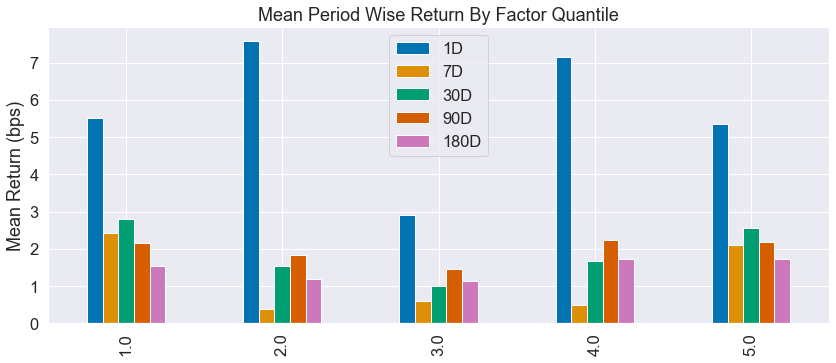

In [44]:
create_summary_tear_sheet(si_change_factor_data, long_short=False)

### 3. Identifying the smartest smart money

We will be evaluating the TWRR for each ticker for each investor. Actually it is not strictly the TWRR because we don't know the cash position size, only the position relative to the market cap. Thus this calculation treats a 10% return on a 1% stake in a company identicaly regardless of the size of the company (with each company being equal-weighted by a given investor). This is obviously not correct, but it is difficult to acquire market cap data so it'll have to do.

As always, I figure out the logic for one particular instance (Marshall Wace's investment into Sainsbury's), then write an iterative solution, then (try to) write an efficient vectorised operation.

In [45]:
# Merge prices
rets_df = pd.merge(df, prices_melted, how="left", left_on=["date", "ticker"], right_on=["date", "ticker"])
# Remove spuriously large returns, which seem to be from illiquid instruments.
rets_df.head()

,investor,position,date,ticker,price
0,Lombard Odier Asset Management (Europe) Limited,0.46,2018-11-02,FOUR.L,1913.145386
1,Lombard Odier Asset Management (Europe) Limited,0.51,2018-11-01,FOUR.L,1951.408325
2,AlphaGen Capital Limited,0.48,2013-05-16,888.L,139.149078
3,AlphaGen Capital Limited,0.50,2013-04-24,888.L,126.796761
4,Millennium International Management LP,0.49,2017-09-22,888.L,228.430862


In [46]:
# Cumulative return for one 
sains = rets_df[(rets_df.investor == "Marshall Wace LLP") & (rets_df.ticker == "SBRY.L")]
sains = sains.drop_duplicates(subset="date", keep="last").sort_values(by="date").set_index("date")
sains.head()

,investor,position,ticker,price
date,,,,
2014-01-31,Marshall Wace LLP,0.51,SBRY.L,261.756287
2014-02-05,Marshall Wace LLP,0.48,SBRY.L,265.095581
2014-02-11,Marshall Wace LLP,0.54,SBRY.L,264.791992
2014-02-17,Marshall Wace LLP,0.49,SBRY.L,261.983948
2014-02-18,Marshall Wace LLP,0.50,SBRY.L,261.832123


In [47]:
# Compute TWRR
sains["short_ret"] = -sains.price.pct_change().shift(-1)
sains = sains.iloc[:-1, :]  # drop last row
sains.tail()

,investor,position,ticker,price,short_ret
date,,,,,
2019-03-15,Marshall Wace LLP,0.76,SBRY.L,211.611008,-0.017426
2019-04-18,Marshall Wace LLP,0.69,SBRY.L,215.298599,0.051383
2019-04-25,Marshall Wace LLP,0.74,SBRY.L,204.235825,-0.030093
2019-05-02,Marshall Wace LLP,0.67,SBRY.L,210.381805,0.076404
2019-05-13,Marshall Wace LLP,0.59,SBRY.L,194.307693,-0.007786


In [48]:
total_ret = (1 + sains.short_ret).product() - 1
day_delta = (sains.index[-1] - sains.index[0]).days
annualised_ret = (1+total_ret) ** (365/day_delta) - 1
print(f"{100*total_ret:.1f}% returns over {day_delta} days. Annualised = {100*annualised_ret:.1f}%")

-10.6% returns over 1928 days. Annualised = -2.1%


In [49]:
# Test logic
for name, holding in rets_df.groupby(["investor", "ticker"]):
    # Only want the first few
    if name[0] == "BlackRock Investment Management (UK) Limited":
        break
    holding = holding.drop_duplicates(subset="date", keep="last").sort_values(by="date").set_index("date")
    holding = holding.dropna()
    if len(holding) < 2:
        continue
    holding["short_ret"] = -holding.price.pct_change().shift(-1)
    total_ret = (1 + holding.short_ret).product() - 1
    day_delta = (holding.index[-1] - holding.index[0]).days
    # (simple) annualised returns
    annualised_ret = total_ret * 365/day_delta    
    if np.isnan(annualised_ret):
        print(name)
        break
    print(f"{100*total_ret:.1f}% returns over {day_delta} days. Annualised = {100*annualised_ret:.1f}%")

27.3% returns over 63 days. Annualised = 158.0%
-2.2% returns over 32 days. Annualised = -24.7%
30.3% returns over 178 days. Annualised = 62.1%
-2.5% returns over 6 days. Annualised = -152.7%
4.2% returns over 8 days. Annualised = 192.2%
-4.3% returns over 7 days. Annualised = -221.9%
26.9% returns over 95 days. Annualised = 103.5%
-13.4% returns over 30 days. Annualised = -162.5%
-96.3% returns over 461 days. Annualised = -76.3%
-2.8% returns over 250 days. Annualised = -4.0%
6.2% returns over 1024 days. Annualised = 2.2%
-7.2% returns over 497 days. Annualised = -5.3%
4.5% returns over 10 days. Annualised = 164.1%
-3.9% returns over 364 days. Annualised = -3.9%
1.1% returns over 28 days. Annualised = 14.6%
-0.3% returns over 475 days. Annualised = -0.3%
-10.2% returns over 475 days. Annualised = -7.8%
-17.1% returns over 113 days. Annualised = -55.2%
-6.0% returns over 28 days. Annualised = -78.9%
-21.9% returns over 1106 days. Annualised = -7.2%
-0.2% returns over 5 days. Annualised

8.1% returns over 40 days. Annualised = 73.7%
-392.6% returns over 1732 days. Annualised = -82.7%
17.6% returns over 7 days. Annualised = 917.6%
-38.2% returns over 37 days. Annualised = -377.2%
30.3% returns over 1661 days. Annualised = 6.7%
5.9% returns over 38 days. Annualised = 56.5%
28.7% returns over 167 days. Annualised = 62.7%
0.2% returns over 24 days. Annualised = 3.6%
-31.6% returns over 250 days. Annualised = -46.1%
-25.1% returns over 190 days. Annualised = -48.1%
-1.8% returns over 602 days. Annualised = -1.1%
-24.6% returns over 448 days. Annualised = -20.1%
-8.1% returns over 64 days. Annualised = -46.1%
-10.2% returns over 1717 days. Annualised = -2.2%
1.0% returns over 156 days. Annualised = 2.4%
17.5% returns over 214 days. Annualised = 29.8%
-5.2% returns over 34 days. Annualised = -56.0%
0.5% returns over 974 days. Annualised = 0.2%
-8.5% returns over 50 days. Annualised = -62.2%
-12.1% returns over 60 days. Annualised = -73.5%
-25.6% returns over 83 days. Annualis

5.6% returns over 19 days. Annualised = 108.4%
5.0% returns over 16 days. Annualised = 113.0%
5.0% returns over 5 days. Annualised = 361.5%
-36.1% returns over 483 days. Annualised = -27.2%
-19.3% returns over 70 days. Annualised = -100.8%
-42.6% returns over 1541 days. Annualised = -10.1%
2.4% returns over 3 days. Annualised = 288.2%
2.8% returns over 20 days. Annualised = 51.4%
-1.8% returns over 14 days. Annualised = -47.6%
-0.9% returns over 2 days. Annualised = -173.2%
-1.8% returns over 22 days. Annualised = -30.5%
20.3% returns over 592 days. Annualised = 12.5%
0.3% returns over 20 days. Annualised = 4.9%
-10.3% returns over 348 days. Annualised = -10.8%
-21.6% returns over 177 days. Annualised = -44.5%
3.9% returns over 15 days. Annualised = 94.0%
-5.8% returns over 1002 days. Annualised = -2.1%
-290.3% returns over 2144 days. Annualised = -49.4%
-9.8% returns over 115 days. Annualised = -31.0%
-5.8% returns over 29 days. Annualised = -73.0%
49.0% returns over 1210 days. Annual

In [50]:
# Vectorised solution

def compute_rets(grp, verbose=False):
    holding = grp.drop_duplicates(subset="date", keep="last").sort_values(by="date").set_index("date")
    holding["short_ret"] = -holding.price.pct_change().shift(-1)
    holding = holding.dropna()
    if len(holding) < 2:
        total_ret = day_delta = annualised_ret = np.nan
    else:
        total_ret = (1 + holding.short_ret).product() - 1
        day_delta = (holding.index[-1] - holding.index[0]).days
        annualised_ret = total_ret * 365/day_delta
    if verbose:
        print(f"{100*total_ret:.1f}% returns over {day_delta} days. Annualised = {100*annualised_ret:.1f}%")
    return pd.DataFrame([total_ret, day_delta, annualised_ret], index=["short_ret", "day_delta", "short_ret_annualised"]).transpose()

In [51]:
pos_rets_df = rets_df.groupby(["investor", "ticker"]).apply(compute_rets)
pos_rets_df.head(10)

short_ret  day_delta  \
investor                                 ticker                           
12 West Capital Management LP            PURP.L 0        NaN        NaN   
A.R.T. International Holdings (BVI) Ltd. PMO.L  0  -0.021685       25.0   
                                         POG.L  0   0.302631      175.0   
ABC Arbitrage Asset Management           BAB.L  0        NaN        NaN   
                                         FGP.L  0   0.042128        2.0   
                                         RSA.L  0  -0.042554        5.0   
ABCA Opportunities Fund                  NTG.L  0        NaN        NaN   
ADG Trading LLP                          NTG.L  0        NaN        NaN   
AEK (UK) Limited                         NXT.L  0   0.269392       80.0   
AHL Partners LLP                         AGK.L  0        NaN        NaN   

                                                   short_ret_annualised  
investor                                 ticker                          
12 West Capital Management LP            PURP.L 0                   NaN  
A.R.T. International Holdings (BVI) Ltd. PMO.L  0             -0.316596  
                                         POG.L  0              0.631201  
ABC Arbitrage Asset Management           BAB.L  0                   NaN  
                                         FGP.L  0              7.688298  
                                         RSA.L  0             -3.106469  
ABCA Opportunities Fund                  NTG.L  0                   NaN  
ADG Trading LLP                          NTG.L  0                   NaN  
AEK (UK) Limited                         NXT.L  0              1.229103  
AHL Partners LLP                         AGK.L  0                   NaN

In [52]:
pos_rets_df = pos_rets_df.droplevel(2).dropna(how="any").reset_index()
pos_rets_df.head(10)

,investor,ticker,short_ret,day_delta,short_ret_annualised
0,A.R.T. International Holdings (BVI) Ltd.,PMO.L,-0.021685,25.0,-0.316596
1,A.R.T. International Holdings (BVI) Ltd.,POG.L,0.302631,175.0,0.631201
2,ABC Arbitrage Asset Management,FGP.L,0.042128,2.0,7.688298
3,ABC Arbitrage Asset Management,RSA.L,-0.042554,5.0,-3.106469
4,AEK (UK) Limited,NXT.L,0.269392,80.0,1.229103
5,AHL Partners LLP,ASC.L,-0.963258,448.0,-0.784798
6,AHL Partners LLP,BBY.L,-0.027516,218.0,-0.046070
7,AHL Partners LLP,CAPC.L,0.061904,1010.0,0.022371
8,AHL Partners LLP,CINE.L,-0.072392,488.0,-0.054146
9,AHL Partners LLP,CPI.L,-0.038970,349.0,-0.040756


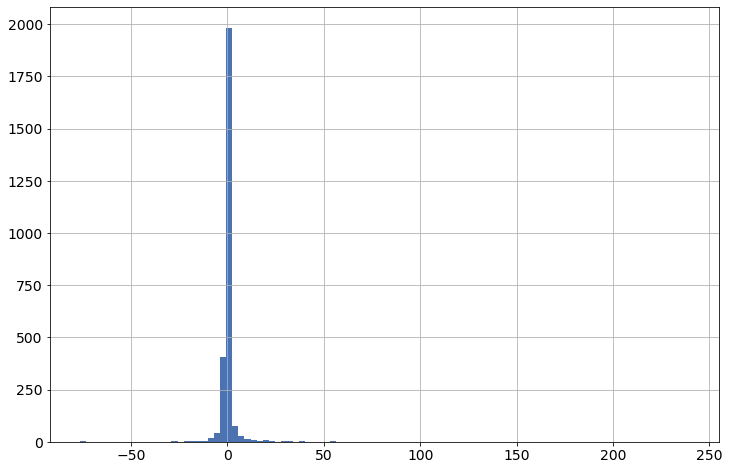

In [53]:
pos_rets_df.short_ret_annualised.hist(bins=100, figsize=(12, 8));

There are some very fat tails because of amazing (or terrible) short-term bets. Thus we may want to only filter companies that have been trading an issue for a reasonable amount of time.

GIPS provision I.5.A.4 explicitly mentions that you must not annualise returns that occured over less than a year. So let's apply this. 

In [54]:
pos_rets_1y = pos_rets_df[pos_rets_df.day_delta > 365]
print(pos_rets_1y.shape)
pos_rets_1y.head()

(1007, 5)


,investor,ticker,short_ret,day_delta,short_ret_annualised
5,AHL Partners LLP,ASC.L,-0.963258,448.0,-0.784798
7,AHL Partners LLP,CAPC.L,0.061904,1010.0,0.022371
8,AHL Partners LLP,CINE.L,-0.072392,488.0,-0.054146
10,AHL Partners LLP,DC.L,-0.003446,441.0,-0.002852
11,AHL Partners LLP,DOM.L,-0.101979,433.0,-0.085964


In [55]:
pos_rets_1y.short_ret_annualised.describe()

count    1007.000000
mean       -0.008396
std         0.473888
min        -7.257511
25%        -0.166393
50%        -0.054082
75%         0.098543
max         5.836775
Name: short_ret_annualised, dtype: float64

In [56]:
print(f"Skew: {pos_rets_1y.short_ret_annualised.skew():.2f}")
print(f"Kurtosis: {pos_rets_1y.short_ret_annualised.kurtosis():.2f}")

Skew: -0.02
Kurtosis: 85.87


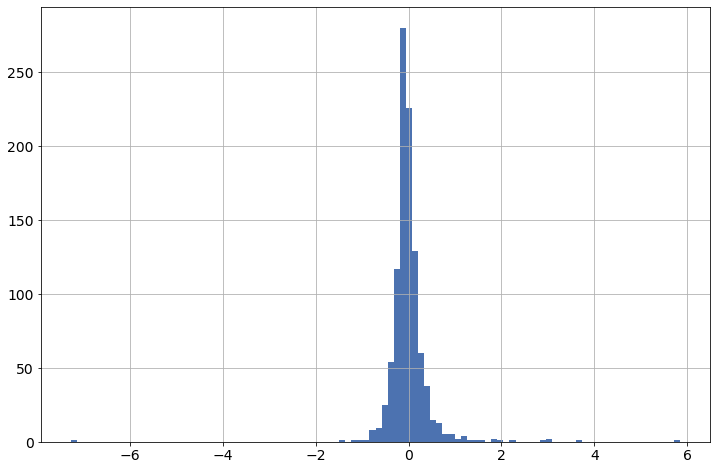

In [57]:
pos_rets_1y.short_ret_annualised.hist(bins=100, figsize=(12,8));

This is much more interesting. Though in aggregrate these short positions perform poorly, there is clearly a group of investors getting it *very* right. The median is -5%, while the mean is about 0. 

We can now try to aggregrate across all the positions that each investor has. For now we will use a simple aggregration procedure and take the mean return for all positions that were interacted with (entered or exited) over the span of more than 365 days. This is *not* the best way of doing things. With this dataset it would be possible to look at the value of all the company's shorts at a given time and track something similar to the change in NAV (except for shorts, and with the caveat that we would be equal-weighting everything) - however I didn't have time to get this done.

In [58]:
investor_rets_1y = pos_rets_1y.groupby("investor")["day_delta", "short_ret_annualised"].mean()
investor_rets_1y = investor_rets_1y.reset_index()
investor_rets_1y.head()

,investor,day_delta,short_ret_annualised
0,AHL Partners LLP,872.076923,-0.087234
1,AKO Capital LLP for AKO Master Fund Limited,1047.833333,0.006143
2,ALLIANCE BERNSTEIN LIMITED,387.000000,0.273471
3,"AQR Capital Management, LLC",1334.414634,-0.066847
4,Adage Capital Management L.P.,1634.000000,-0.525577


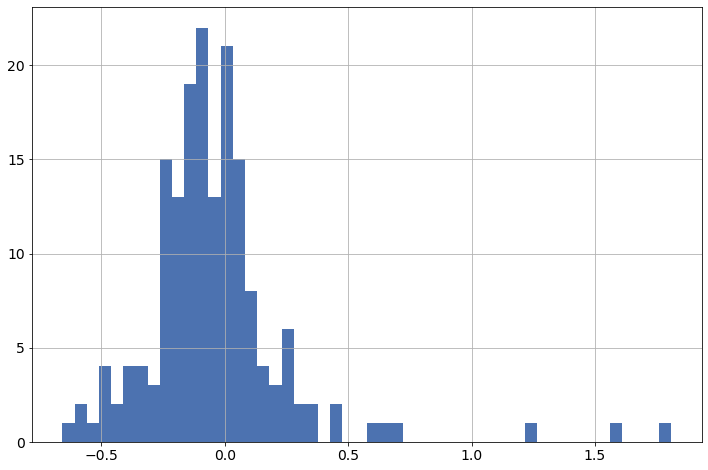

In [59]:
investor_rets_1y.short_ret_annualised.hist(bins=50);

In [60]:
# Top 10 performers
investor_rets_1y.sort_values(by="short_ret_annualised", ascending=False).head(10)

,investor,day_delta,short_ret_annualised
169,"Woodson Capital Management, LP",370.0,1.808251
171,"Yost Capital Management, LP",625.0,1.583013
52,ENA Investment Capital LLP,672.5,1.246587
46,D1 Capital Partners LP,412.0,0.685592
10,Arrowgrass Capital Partners LLP,789.0,0.638838
32,CapeView Capital LLP,836.0,0.583652
154,"The Mangrove Partners Master Fund, Ltd.",994.0,0.447717
25,Bybrook Capital LLP,917.0,0.433685
119,Oslo Asset Management ASA,538.0,0.349924
146,Sculptor Capital LP,736.0,0.343285


In [61]:
# Bottom 10 performers
investor_rets_1y.sort_values(by="short_ret_annualised", ascending=True).head(10)

,investor,day_delta,short_ret_annualised
163,"Valiant Capital Management, LP",651.000,-0.657196
90,Kynikos Associates LP,578.000,-0.589993
64,"Foxhaven Asset Management, LP",581.000,-0.563996
4,Adage Capital Management L.P.,1634.000,-0.525577
41,"Coatue Management, L.L.C.",1077.000,-0.492126
74,Henderson Global Investors,982.125,-0.491091
79,Hunt Lane Capital LP,736.000,-0.481968
84,"Jane Street Group, LLC",637.000,-0.474377
165,Voleon Capital Management LP,366.000,-0.455757
118,OMNI PARTNERS LLP,590.000,-0.447810


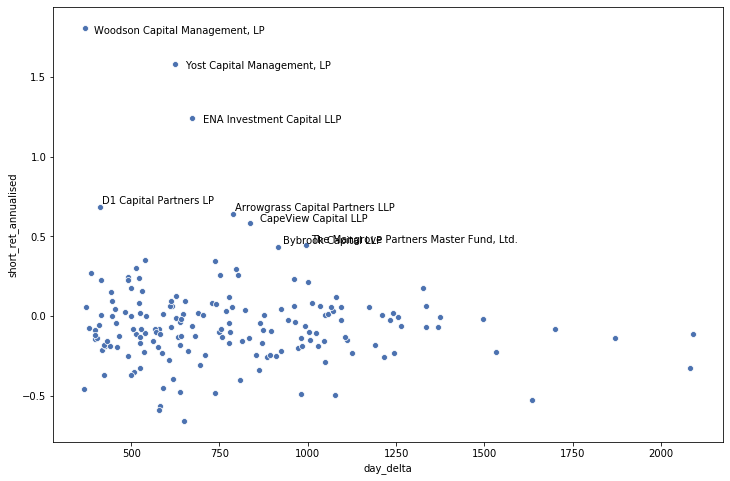

In [62]:
# Plotting both returns and the involvement period
plt.rcParams['font.size'] = 10
ax = sns.scatterplot(x="day_delta", y="short_ret_annualised", data=investor_rets_1y)

for _, p in investor_rets_1y.iterrows():
    if p.short_ret_annualised > 0.4:
       ax.text(p.day_delta + np.random.uniform(0, 50), 
               p.short_ret_annualised + np.random.uniform(-0.05, 0.05),
               p.investor)